<a href="https://colab.research.google.com/github/sb2399/cs301-project/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [124]:
import jax 
import jax.numpy as jnp
import pandas as pd
import seaborn as sns

# Loading Transaction Data

In [125]:
transactions = pd.read_csv("transactions.csv")
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions = transactions[['t_dat', 'customer_id', 'article_id']]
transactions1 = transactions # save this for the original dataset
print('Transactions shape:', transactions.shape)

Transactions shape: (760209, 3)


In [126]:
transactions.head()

,t_dat,customer_id,article_id
0,2020-09-02,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,820671001
1,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,882354001
2,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,817354001
3,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,817354001
4,2020-09-02,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,899002003


Text(0.5, 1.0, 'Transactions by Date')

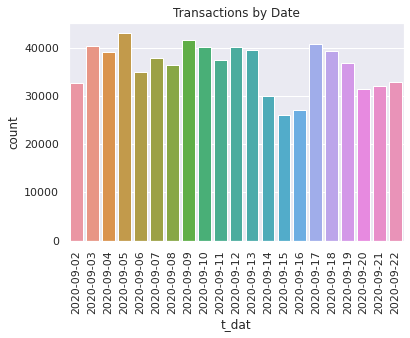

In [127]:
sns.set_theme(style='darkgrid')
ax = sns.countplot(x=pd.to_datetime(transactions['t_dat']).dt.date, data=transactions)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Transactions by Date')

# Finding each customer's last week of transactions

In [128]:
temp = transactions.groupby('customer_id')['t_dat'].max().reset_index()
temp.columns = ['customer_id', 'max_dat']

'max_dat' is the date of each customer's most recent purchase.

In [129]:
transactions = transactions.merge(temp, on=['customer_id'], how='left')
transactions['diff_dat'] = (transactions['max_dat'] - transactions['t_dat']).dt.days

'diff_dat' is the difference in days between the customer's current purchase ('t_dat') and the customer's most recent purchase ('max_dat'). 

When 'diff_dat' is less than or equal to 6, the two purchases are within the same week.


In [130]:
transactions = transactions.loc[transactions['diff_dat'] <= 6]
print('Transactions shape:', transactions.shape)

Transactions shape: (666054, 5)


In [131]:
transactions.head()

,t_dat,customer_id,article_id,max_dat,diff_dat
0,2020-09-02,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,820671001,2020-09-02,0
1,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,882354001,2020-09-06,4
2,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,817354001,2020-09-06,4
3,2020-09-02,0006bfcec82c6c132276c0a5549ae13645c9ab77b0243f...,817354001,2020-09-06,4
4,2020-09-02,000ed4cabda96069b547ae531c66de5f1bf6a7e5b83aa8...,899002003,2020-09-02,0


# Finding most frequently purchased items from the past week

In [132]:
temp = transactions.groupby(['customer_id','article_id'])['t_dat'].agg('count').reset_index()

This counts the number of times the article was purchased by a customer. This allows us to see the most frequently purchased items for a customer by sorting the data frame to have higher counts shown first.

In [133]:
temp.columns = ['customer_id', 'article_id', 'count']
transactions = transactions.merge(temp, on=['customer_id', 'article_id'], how='left')
transactions = transactions.drop_duplicates(['customer_id', 'article_id'])
transactions = transactions.sort_values(['count', 't_dat'], ascending=False)
transactions.head()

,t_dat,customer_id,article_id,max_dat,diff_dat,count
350479,2020-09-13,61da44a2758206d5701771f4315637b40c8321b5111916...,850917001,2020-09-13,0,58
197853,2020-09-08,e719397d58d169e4852fad0763c7540258ad1bf6f012a8...,850917003,2020-09-08,0,38
131402,2020-09-06,a75fa15376e0597c35176abbf99277fd4bde2f43df7108...,717464001,2020-09-12,6,38
245577,2020-09-10,50bd9f7c0abe0a4c00d30cb8e7cdef54ac9b2242725c74...,685814001,2020-09-10,0,35
108694,2020-09-05,d974419e4042b777043fba277321b16abab13348203b9f...,685813001,2020-09-05,0,35


Text(0.5, 1.0, 'Top 20 Most Frequently Purchased Items by Customers')

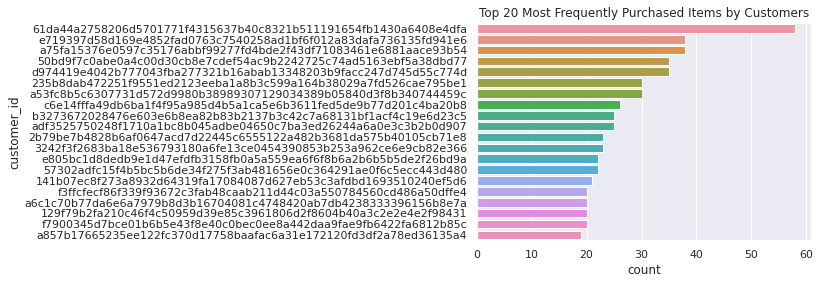

In [134]:
sns.barplot(x='count', y='customer_id',data=transactions.nlargest(20, 'count')).set_title('Top 20 Most Frequently Purchased Items by Customers')

# Recommend Items Purchased Together

This dictionary stores information about the other purchases from a customer that has already bought a specific article. The key of this dictionary is a unique pair of a 'customer_id' and an 'article_id', representing a single article transaction for a customer. The values of the dictionary represent three other items that this customer has purchased, not including the article in the key, as their 'article_id's.

In [135]:
transactions = transactions1 # original dataset
vc = transactions['article_id'].value_counts()
pairs = {}

for j, i in enumerate(vc.index.values[1000:1032]):
    # key: represents unique combinations of articles & customers
    USERS = transactions.loc[transactions['article_id'] == i.item(), 'customer_id'].unique()
    # value: represents other articles that this customer has purchased
    vc2 = transactions.loc[(transactions['customer_id'].isin(USERS)) &
                           (transactions['article_id'] != i.item()), 'article_id'].value_counts()
    pairs[i.item()] = [vc2.index[0], vc2.index[1], vc2.index[2]]

transactions['article_id2'] = transactions['article_id'].map(pairs)

To recommend this items stored as values of the dictionary, these 'article_id's will be stored in 'article_id2' as a list.

In [136]:
transactions2 = transactions[['customer_id', 'article_id2']].copy()
transactions2 = transactions2.loc[transactions2['article_id2'].notnull()]
transactions2 = transactions2.loc[transactions2.astype(str).
                                  drop_duplicates(subset=['customer_id', 'article_id2']).index]
transactions2 = transactions2.rename({'article_id2':'article_id'})
transactions2.head()

,customer_id,article_id2
74,00b1b2b8c27c20887113ca50adafd9593762297cd8aa81...,"[915453005, 915453002, 912095007]"
123,0100808c6880016290b28744ad47d8c8e3c29f5b3ee32a...,"[562245046, 750422039, 578476001]"
252,01d95e83aa2b8c038639ac2dfbbf4d57f3ca44d04bbd33...,"[706016038, 867966009, 706016001]"
523,038d7a0d8adf79eb8e49cc1498d76ce2aca53af4d2aa74...,"[253448003, 253448002, 470789001]"
728,04cf2afeeb4b5c9a312f274d489ce9b44d06b55ef2f02d...,"[871517016, 688728023, 803969007]"


Now, we combine the recommendations from the most frequently purchased articles and the recommendations from the items purchased together. 

`transactions` contains the most frequently purchased articles while `transactions2` contains the list of items purchased together.



In [137]:
transactions = transactions[['customer_id', 'article_id']]
transactions = pd.concat([transactions, transactions2], axis=0, ignore_index=True)
transactions = transactions.loc[transactions.astype(str).
                                  drop_duplicates(subset=['customer_id', 'article_id']).index]

We combine these recommendations into a single string for each customer_id.

In [138]:
transactions['article_id'] = ' 0' + transactions['article_id'].astype('str').replace(
    '\.0', ' ', regex=True)
preds = pd.DataFrame(transactions.groupby('customer_id').article_id.sum().reset_index())
preds.columns = ['customer_id', 'prediction']
preds.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0719530003 0448509014
3,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0685814001
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0572998013 0909869004 0923134003 093585800...


# Recommending most popular items in the past month

We are finding the 12 most popular items in the month of September to recommend for customers after using the predictions above. This is because the most popular items are frequently purchased in general, so this is a good prediction for all customers. We are using the data from the month of September since it is the most recent data provided to us.

In [139]:
transactions = transactions1 # original dataframe from dataset
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions = transactions.loc[transactions['t_dat'] >= pd.to_datetime('2020-09-01')]
top12 = ' 0'.join(transactions['article_id'].value_counts().index.astype('str')[:12])
print("12 most popular items in September (from 09/01/2020 to 09/22/2020):")
print(top12)

12 most popular items in September (from 09/01/2020 to 09/22/2020):
909370001 0751471001 0918522001 0924243001 0448509014 0918292001 0751471043 0915529003 0915526001 0706016001 0865799006 0863595006


# Final Recommendations

Creating list of 12 recommendations for each customer by combining the predictions found above and filling in the rest of the 12 spots with the most popular items in September

In [141]:
sub = pd.read_csv('sample_submission.csv')
sub = sub[['customer_id']]
sub = sub.merge(preds, on='customer_id', how='left').fillna('')
sub.prediction = sub.prediction + top12
sub.prediction = sub.prediction.str.strip()
sub.prediction = sub.prediction.str[:131]
sub.to_csv(f'submission.csv',index=False)
sub.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 909370001 0751471001 0918522001 092...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,909370001 0751471001 0918522001 0924243001 044...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 909370001 0751471001 0918522001 092...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,909370001 0751471001 0918522001 0924243001 044...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,909370001 0751471001 0918522001 0924243001 044...


Finding the number of unique articles that are recommended for all customers (this code block below takes about 6 minutes to run)

In [142]:
recommendations = []
for index in preds['prediction']:
  index = index.split()
  recommendations = list(set(recommendations + index))
print(len(recommendations))

25900


There are 25,900 unique articles + 12 most popular articles = 25,912 unique articles recommended

# Evaluating the Model

The Kaggle competition scores each notebook based on the Mean Average Precision @12. We used [this notebook](https://www.kaggle.com/code/kaerunantoka/h-m-how-to-calculate-map-12/notebook) as a reference for calculating the MAP@12 for our model.

In [143]:
sub = pd.read_csv('sample_submission.csv')
del sub['prediction']
transactions = transactions1 # original dataset
val_start_date = '2020-09-15' # one week of validation data
train_data = transactions.query(f"t_dat < '{val_start_date}'").reset_index(drop=True)
valid_data = transactions.query(f"t_dat >= '{val_start_date}'").reset_index(drop=True)

In [144]:
train_group = train_data.groupby('customer_id')['article_id'].apply(list).reset_index()
train_group['valid_pred'] = train_group['article_id'].map(lambda x: '0'+' 0'.join(str(x)[1:-1].split(', ')))
train_group.head()

,customer_id,article_id,valid_pred
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,[568601043],0568601043
1,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[719530003, 448509014]",0719530003 0448509014
2,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,"[685814001, 685814001, 685814001]",0685814001 0685814001 0685814001
3,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"[572998013, 909869004, 923134003, 935858001, 8...",0572998013 0909869004 0923134003 0935858001 08...
4,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,[820671001],0820671001


In [145]:
valid_group = valid_data.groupby('customer_id')['article_id'].apply(list).reset_index()
valid_group['valid_true'] = valid_group['article_id'].map(lambda x: '0'+' 0'.join(str(x)[1:-1].split(', ')))
valid_group.head()

,customer_id,article_id,valid_true
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[794321007],0794321007
1,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,[624486001],0624486001
2,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,[827487003],0827487003
3,00040239317e877c77ac6e79df42eb2633ad38fcac09fc...,"[875272011, 875272012]",0875272011 0875272012
4,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,"[757926001, 788575004, 640021019]",0757926001 0788575004 0640021019


In [146]:
merged = pd.merge(sub, train_group, on='customer_id', how='left').fillna('')
merged = pd.merge(merged, valid_group, on='customer_id', how='left').fillna('')

del merged['article_id_x'], merged['article_id_y']
merged.head()

,customer_id,valid_pred,valid_true
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043,
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,,
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,,0794321007
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,,
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,,


In [147]:
merged = merged[merged['valid_true']!=''].reset_index(drop=True)
print(merged.shape)
merged.head()

(75481, 3)


,customer_id,valid_pred,valid_true
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,,0794321007
1,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,,0624486001
2,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0913367001 0904026001 0905914002 0640021012 06...,0827487003
3,00040239317e877c77ac6e79df42eb2633ad38fcac09fc...,0875272011 0875272012,0875272011 0875272012
4,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0399136061 0732842014 0556255001 0852219003 07...,0757926001 0788575004 0640021019


In [148]:
import numpy as np
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [149]:
print('Mean average precision @12 =', mapk(
    merged['valid_true'].map(lambda x: x.split()),
     merged['valid_pred'].map(lambda x:x.split()),
     k = 12
))

Mean average precision @12 = 0.014121533462046879


# Kaggle Entries Used as a Reference

[Items Purchased Together Kaggle Entry](https://www.kaggle.com/code/cdeotte/recommend-items-purchased-together-0-021): We used this entry as a reference for ideas of grouping customers and articles, and how to recommend new articles from the data.

[How to Calculate MAP12](https://www.kaggle.com/code/kaerunantoka/h-m-how-to-calculate-map-12/notebook): We used this entry as a way of calculating the Mean Average Precision @ 12 by using the functions from their code.